In [1]:
#!pip install pyyaml==5.1
#!pip install opencv-contrib-python
# python3 -m ipykernel
import torch
import cv2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
CV2_VERSION = cv2.__version__
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION, ";CV2: ", CV2_VERSION)

torch:  1.10 ; cuda:  cu113 ;CV2:  4.5.4-dev


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

In [3]:
## Import dataset
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_set", {}, "./flora/annotations/instances_default.json", "./flora/images")

In [4]:
fucus_metadata = MetadataCatalog.get("train_set")

In [5]:
fucus_metadata

namespace(name='train_set',
          json_file='./flora/annotations/instances_default.json',
          image_root='./flora/images',
          evaluator_type='coco')

In [6]:
dataset_dicts = DatasetCatalog.get("train_set")

[11/18 20:19:13 d2.data.datasets.coco]: Loaded 148 images in COCO format from ./flora/annotations/instances_default.json


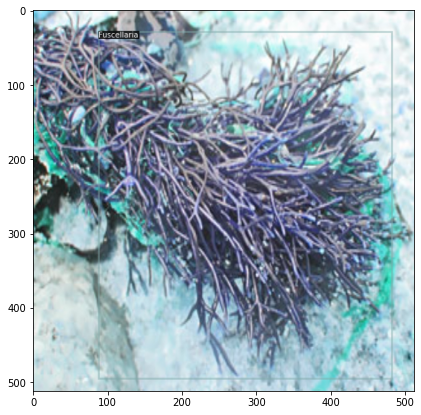

In [7]:
# Visualize dataset
plt.rcParams['figure.figsize'] = [15, 7]
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fucus_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [8]:
## Train

from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_set",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00125
cfg.SOLVER.MAX_ITER = 1600
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here. (copied from the official detectron2 tutorial)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/18 20:19:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/18 20:19:31 d2.data.datasets.coco]: Loaded 148 images in COCO format from ./flora/annotations/instances_default.json
[11/18 20:19:31 d2.data.build]: Removed 0 images with no usable annotations. 148 images left.
[11/18 20:19:31 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
|   Fucus    | 57           |  Zostera   | 57           | Fuscellaria | 51           |
|            |              |            |              |             |              |
|   total    | 165          |            |              |             |              |
[11/18 20:19:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/18 20:19:31 d2.data.build]: Using training sampler T

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[11/18 20:19:32 d2.engine.train_loop]: Starting training from iteration 0


/illukas/home/jgalin/Detectron2/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/18 20:19:38 d2.utils.events]:  eta: 0:05:57  iter: 19  total_loss: 1.287  loss_cls: 1.209  loss_box_reg: 0.09223  loss_rpn_cls: 0.004238  loss_rpn_loc: 0.009176  time: 0.2243  data_time: 0.0303  lr: 2.4976e-05  max_mem: 4039M
[11/18 20:19:42 d2.utils.events]:  eta: 0:06:06  iter: 39  total_loss: 0.7011  loss_cls: 0.5147  loss_box_reg: 0.1054  loss_rpn_cls: 0.01351  loss_rpn_loc: 0.01083  time: 0.2301  data_time: 0.0025  lr: 4.9951e-05  max_mem: 4039M
[11/18 20:19:47 d2.utils.events]:  eta: 0:05:52  iter: 59  total_loss: 0.2607  loss_cls: 0.1354  loss_box_reg: 0.08993  loss_rpn_cls: 0.007182  loss_rpn_loc: 0.00695  time: 0.2269  data_time: 0.0025  lr: 7.4926e-05  max_mem: 4039M
[11/18 20:19:51 d2.utils.events]:  eta: 0:05:47  iter: 79  total_loss: 0.1939  loss_cls: 0.09527  loss_box_reg: 0.08935  loss_rpn_cls: 0.003298  loss_rpn_loc: 0.007382  time: 0.2265  data_time: 0.0025  lr: 9.9901e-05  max_mem: 4039M
[11/18 20:19:56 d2.utils.events]:  eta: 0:05:43  iter: 99  total_loss: 0.1696

[11/18 20:22:18 d2.utils.events]:  eta: 0:03:33  iter: 699  total_loss: 0.07817  loss_cls: 0.02551  loss_box_reg: 0.04378  loss_rpn_cls: 0.000155  loss_rpn_loc: 0.005696  time: 0.2335  data_time: 0.0025  lr: 0.00087413  max_mem: 4039M
[11/18 20:22:23 d2.utils.events]:  eta: 0:03:28  iter: 719  total_loss: 0.08555  loss_cls: 0.03182  loss_box_reg: 0.05178  loss_rpn_cls: 0.0005365  loss_rpn_loc: 0.005369  time: 0.2338  data_time: 0.0024  lr: 0.0008991  max_mem: 4039M
[11/18 20:22:28 d2.utils.events]:  eta: 0:03:24  iter: 739  total_loss: 0.06133  loss_cls: 0.0188  loss_box_reg: 0.03874  loss_rpn_cls: 0.0001716  loss_rpn_loc: 0.005493  time: 0.2339  data_time: 0.0024  lr: 0.00092408  max_mem: 4039M
[11/18 20:22:32 d2.utils.events]:  eta: 0:03:19  iter: 759  total_loss: 0.09345  loss_cls: 0.0269  loss_box_reg: 0.05343  loss_rpn_cls: 0.0001075  loss_rpn_loc: 0.004474  time: 0.2338  data_time: 0.0025  lr: 0.00094905  max_mem: 4039M
[11/18 20:22:37 d2.utils.events]:  eta: 0:03:14  iter: 779  

[11/18 20:24:59 d2.utils.events]:  eta: 0:00:52  iter: 1379  total_loss: 0.03937  loss_cls: 0.01069  loss_box_reg: 0.02492  loss_rpn_cls: 7.131e-05  loss_rpn_loc: 0.003489  time: 0.2340  data_time: 0.0024  lr: 0.00125  max_mem: 4039M
[11/18 20:25:03 d2.utils.events]:  eta: 0:00:47  iter: 1399  total_loss: 0.04027  loss_cls: 0.01168  loss_box_reg: 0.02437  loss_rpn_cls: 1.66e-05  loss_rpn_loc: 0.002496  time: 0.2339  data_time: 0.0023  lr: 0.00125  max_mem: 4039M
[11/18 20:25:08 d2.utils.events]:  eta: 0:00:42  iter: 1419  total_loss: 0.03193  loss_cls: 0.007665  loss_box_reg: 0.01942  loss_rpn_cls: 4.314e-05  loss_rpn_loc: 0.002472  time: 0.2339  data_time: 0.0026  lr: 0.00125  max_mem: 4039M
[11/18 20:25:13 d2.utils.events]:  eta: 0:00:38  iter: 1439  total_loss: 0.03369  loss_cls: 0.007895  loss_box_reg: 0.02148  loss_rpn_cls: 1.48e-05  loss_rpn_loc: 0.00347  time: 0.2339  data_time: 0.0024  lr: 0.00125  max_mem: 4039M
[11/18 20:25:18 d2.utils.events]:  eta: 0:00:33  iter: 1459  tota

In [11]:
%load_ext tensorboard
%tensorboard --logdir output

In [18]:
# Validation dataset
## Import dataset
from detectron2.data.datasets import register_coco_instances
register_coco_instances("validation_set", {}, "./flora_val/annotations/instances_default.json", "./flora_val/images")

In [19]:
validation_metadata = MetadataCatalog.get("validation_set")
validation_metadata

namespace(name='validation_set',
          json_file='./flora_val/annotations/instances_default.json',
          image_root='./flora_val/images',
          evaluator_type='coco')

In [20]:
dataset_dicts_val = DatasetCatalog.get("validation_set")

[11/18 21:26:39 d2.data.datasets.coco]: Loaded 15 images in COCO format from ./flora_val/annotations/instances_default.json


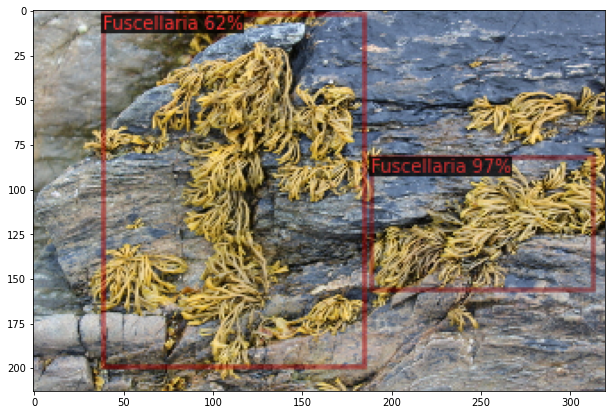

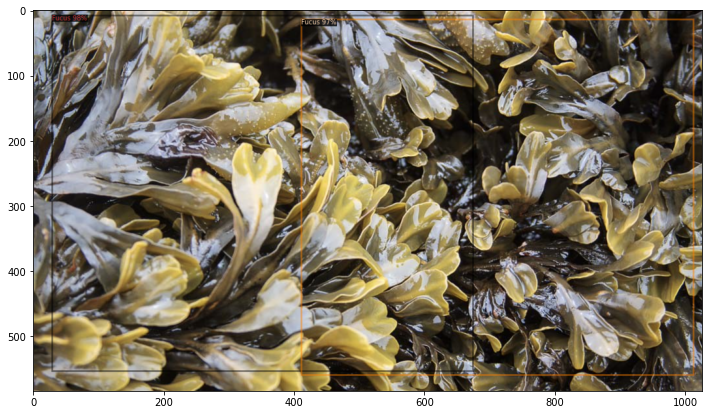

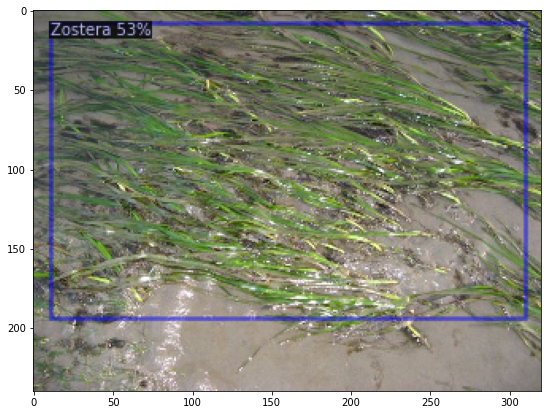

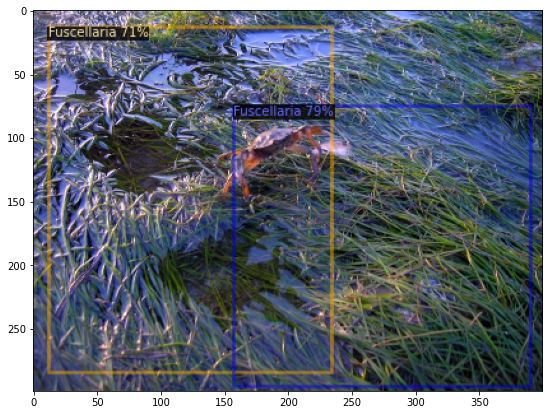

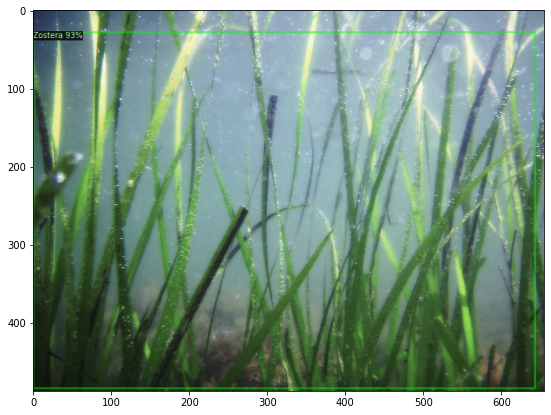

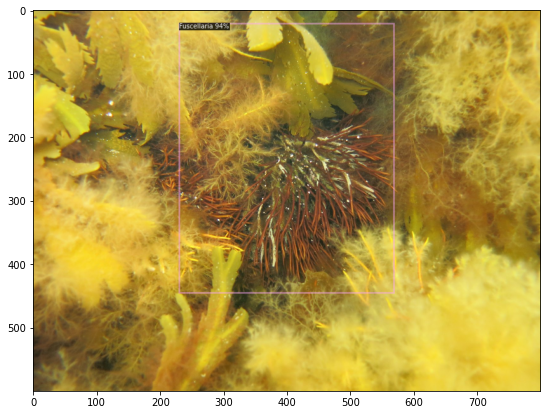

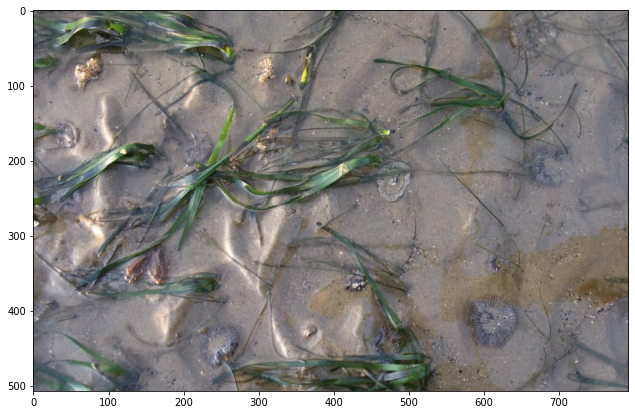

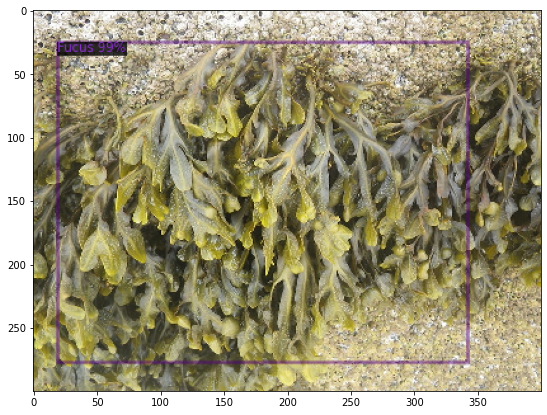

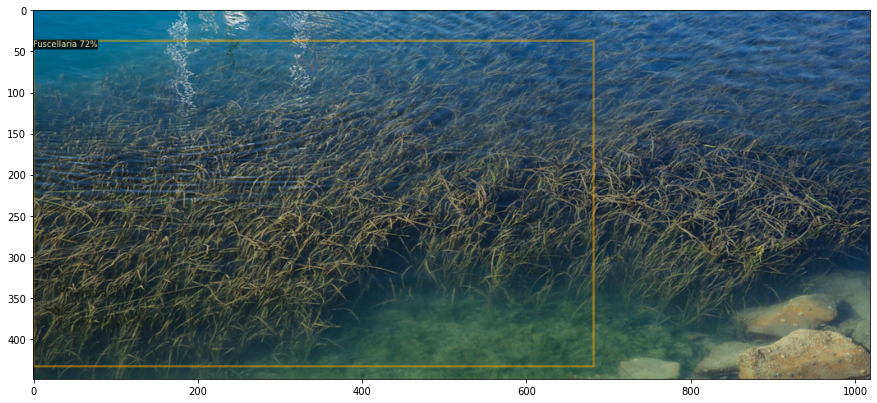

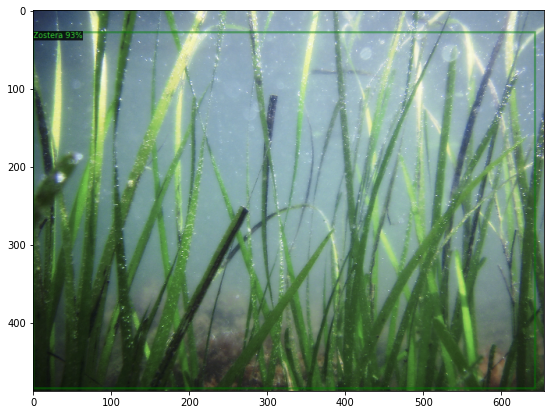

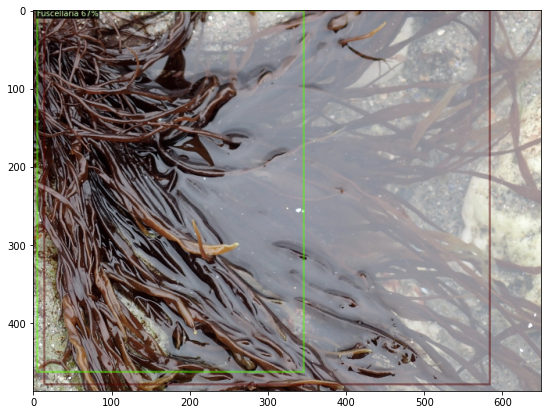

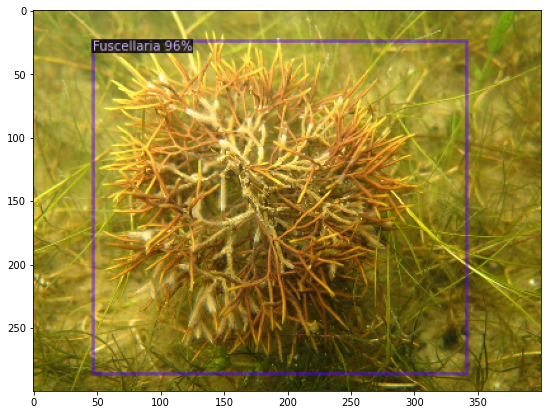

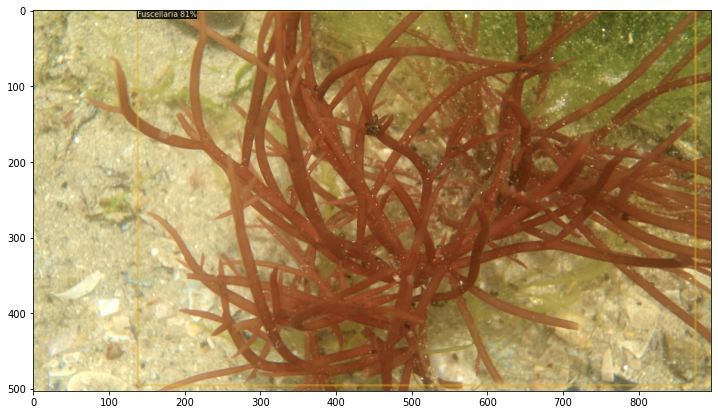

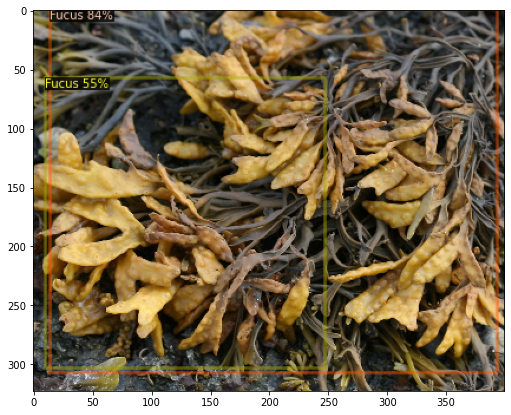

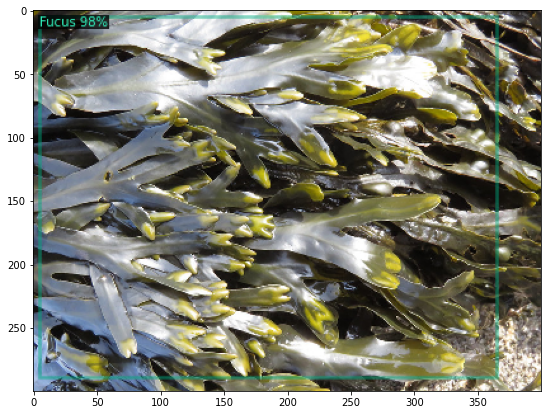

In [29]:
## Inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
predictor = DefaultPredictor(cfg)
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import load_coco_json

for d in random.sample(dataset_dicts_val, 15):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
        MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
        scale=0.5)
        #instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB))

In [28]:
## Evaluation test set
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("validation_set", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "validation_set")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [11/18 22:39:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/18 22:39:49 d2.data.datasets.coco]: Loaded 15 images in COCO format from ./flora_val/annotations/instances_default.json
[11/18 22:39:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/18 22:39:49 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[11/18 22:39:49 d2.data.common]: Serialized dataset takes 0.00 MiB
[11/18 22:39:49 d2.evaluation.evaluator]: Start inference on 15 batches
[11/18 22:39:50 d2.evaluation.evaluator]: Inference done 11/15. Dataloading: 0.0007 s/iter. Inference: 0.0655 s/iter. Eval: 0.0001 s/iter. Total: 0.0663 s/iter. ETA=0:00:00
[11/18 22:39:51 d2.evaluation.evaluator]: Total inference time: 0:00:00.739493 (0.073949 s / iter per device, o

In [30]:
## Evaluation train set
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("train_set", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "train_set")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [11/18 23:07:13 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/18 23:07:13 d2.data.datasets.coco]: Loaded 148 images in COCO format from ./flora/annotations/instances_default.json
[11/18 23:07:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/18 23:07:13 d2.data.common]: Serializing 148 elements to byte tensors and concatenating them all ...
[11/18 23:07:13 d2.data.common]: Serialized dataset takes 0.04 MiB
[11/18 23:07:13 d2.evaluation.evaluator]: Start inference on 148 batches
[11/18 23:07:14 d2.evaluation.evaluator]: Inference done 11/148. Dataloading: 0.0007 s/iter. Inference: 0.0488 s/iter. Eval: 0.0001 s/iter. Total: 0.0497 s/iter. ETA=0:00:06
[11/18 23:07:19 d2.evaluation.evaluator]: Inference done 112/148. Dataloading: 0.0007 s/iter. Inference: 0.0490

In [30]:
## Saving the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

In [ ]:
# Load model
import torch
new_cfg = get_cfg()
new_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
new_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
new_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
new_cfg.MODEL.WEIGHTS = "./output/model_final.pth"